In [1]:
from __future__ import print_function, division

In [57]:
# import libraries
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import scale
from sklearn.decomposition import KernelPCA
from sklearn.linear_model import Ridge, ElasticNet, BayesianRidge
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [58]:
# update your data path
DATA_PATH = "/home/aunagar/Personal/Study/Sem1/Advanced ML/projects/task1/Task1/"

In [69]:
# import data
train_X = pd.read_csv(DATA_PATH + "X_train.csv")
train_Y = pd.read_csv(DATA_PATH + "y_train.csv")
test_X = pd.read_csv(DATA_PATH + "X_test.csv")
sample_submission = pd.read_csv(DATA_PATH + "sample.csv")

In [70]:
# split data
train_ids = train_X.iloc[:, 0]
train_features = train_X.iloc[:, 1:]
test_ids = test_X.iloc[:, 0]
test_features = test_X.iloc[:, 1:]

In [71]:
######## missing value imputation (median) ########
# train
train_features = train_features.fillna(train_features.mean())
# test
test_features = test_features.fillna(train_features.mean())


####### limiting feature using variance threshold (i.e. remove features with 0 variance) ######
train_features_mean, train_features_std = train_features.mean(), train_features.std()

train_features = train_features.iloc[:, np.where(train_features_std > 0.0)[0]]
test_features = test_features.iloc[:, np.where(train_features_std > 0.0)[0]]

############## Outlier removal ###############
train_features_mean, train_features_std = train_features.mean(), train_features.std()
# train
train_features[train_features > train_features_mean + 3.*train_features_std] = np.nan
train_features[train_features < train_features_mean -3.*train_features_std] = np.nan
train_features = train_features.fillna(train_features.mean())

# test
test_features[test_features > train_features_mean + 3.*train_features_std] = np.nan
test_features[test_features < train_features_mean - 3.*train_features_std] = np.nan
test_features = test_features.fillna(train_features.mean())

In [72]:
##### Normalization (median) #####
# train
train_mean, train_std = train_features.median(), train_features.std()
train_features = (train_features - train_mean)/train_std
# test 
test_features = (test_features - train_mean)/train_std

In [73]:
###### Correlated feature removal #########
# Create correlation matrix
corr_matrix = train_features.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.7
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

# train
train_features = train_features.drop(columns = to_drop)
# test
test_features = test_features.drop(columns = to_drop)

In [74]:
###### linear model
lr = ElasticNet(alpha = 0.5, l1_ratio=0.5)
validation_score = cross_val_score(lr, train_features, train_Y.iloc[:, 1:], cv = 5, scoring = 'r2')
print(validation_score.mean())

# train model on whole train data
lr.fit(X = train_features, y = train_Y.iloc[:, 1])

0.42487022151743564


ElasticNet(alpha=0.5, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [75]:
# finding to which features to remove
non_zero_weights = np.where(lr.coef_ != 0.)[0]

# removing these features from training data
train_features = train_features.iloc[:, non_zero_weights]
test_features = test_features.iloc[:, non_zero_weights]

In [76]:
### Checking if log transformation helps
original_corr_Y = train_features.corrwith(train_Y['y'], axis = 0)

log_normalized_features = np.log(train_features + 100)
log_normalized_features.iloc[:,0:-1] = log_normalized_features.iloc[:,0:-1].apply(lambda x: (x-x.mean())/ x.std(), axis=0)

log_corr_Y = np.log((train_features+100)).corrwith(train_Y['y'], axis = 0)

columns_to_transform = np.where(original_corr_Y.values < log_corr_Y.values)[0]

In [77]:
train_features.iloc[:, columns_to_transform] = train_features.iloc[:, columns_to_transform].apply(
                                    lambda x:(np.log(x+100) - np.log(x+100).mean())/(np.log(x+100).std()), axis = 0)
test_features.iloc[:, columns_to_transform] = test_features.iloc[:, columns_to_transform].apply(
                                    lambda x:(np.log(x+100) - np.log(x+100).mean())/(np.log(x+100).std()), axis = 0)

In [78]:
#### training more complex model on this cleared date
gbr = GradientBoostingRegressor(loss='huber', learning_rate=0.05, n_estimators=1000, subsample=0.9,
                                criterion='friedman_mse', min_samples_split=10, min_samples_leaf=10,
                                min_weight_fraction_leaf=0.0, max_depth=7, min_impurity_decrease=0.0,
                                min_impurity_split=None, init=None, random_state=42, max_features=None,
                                alpha=0.9, verbose=1, max_leaf_nodes=None, warm_start=False, presort='auto',
                                validation_fraction=0.33, n_iter_no_change=None, tol=0.0001)
validation_score = cross_val_score(gbr, train_features, train_Y.iloc[:, 1], cv = 5, scoring= 'r2')
print(validation_score.mean())

gbr.fit(X= train_features, y = train_Y.iloc[:, 1].values)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1          44.8414           1.5404           46.81s
         2          40.6868           2.1040           45.55s
         3          38.2829           1.5243           45.38s
         4          36.1962           1.2488           45.53s
         5          32.8489           1.3418           48.95s
         6          31.8524           1.2189           50.67s
         7          29.4075           1.3389           50.76s
         8          26.9827           1.4755           52.59s
         9          24.9205           1.4216           52.55s
        10          24.4293           0.9961           52.27s
        20          13.4446           0.3003           46.89s
        30           8.0492           0.1486           47.57s
        40           5.2728           0.0385           46.03s
        50           3.4944           0.0476           45.46s
        60           2.4517           0.0223           43.78s
       

        80           1.3821           0.0093           35.84s
        90           1.0589           0.0185           35.11s
       100           0.8654          -0.0002           34.48s
       200           0.1689           0.0006           28.72s
       300           0.0490          -0.0002           24.43s
       400           0.0229           0.0008           20.55s
       500           0.0148           0.0000           16.82s
       600           0.0086           0.0000           13.27s
       700           0.0060           0.0002            9.88s
       800           0.0068          -0.0000            6.54s
       900           0.0060           0.0001            3.24s
      1000           0.0073          -0.0000            0.00s
0.5210446401337014
      Iter       Train Loss      OOB Improve   Remaining Time 
         1          45.3458           2.3606           51.41s
         2          42.8138           1.7092           51.16s
         3          40.9087           1.6595      

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.05, loss='huber', max_depth=7,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=0.9, tol=0.0001,
                          validation_fraction=0.33, verbose=1,
                          warm_start=False)

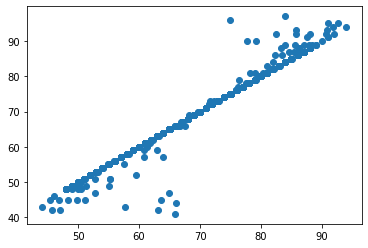

In [50]:
plt.scatter(gbr.predict(train_features), train_Y.iloc[:, 1])
plt.show()

In [21]:
best_model = gbr

In [22]:
predicted = best_model.predict(test_features)
sample_submission['y'] = predicted

In [23]:
sample_submission.to_csv("submissions/Ajay_11th_sub.csv", index = False)